In [139]:
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np

In [140]:
g = ig.Graph.Read_GraphML('data/grafos_limpos/Florida Key islands, Florida Bay, USA.graphml')
len(g.vs())

/tmp/ipykernel_16942/501166983.py:1: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. Location: src/io/graphml.c:434
  g = ig.Graph.Read_GraphML('data/grafos_limpos/Florida Key islands, Florida Bay, USA.graphml')


108

In [141]:
def printar_estatistica(dados, estatistica):
    df = pd.DataFrame(dados)

    # Ordena pelo Betweenness
    df_ordenado = df.sort_values(by=estatistica, ascending=False)

    # Configurações opcionais para melhorar a exibição no terminal
    pd.set_option('display.max_rows', None) # Mostra todas as linhas (cuidado se for gigante)
    pd.set_option('display.float_format', '{:.6f}'.format) # Formata decimais

    print("--- Resultados Ordenados (Pandas DataFrame) ---")
    print(df_ordenado.to_string(index=False)) # index=False remove o número da linha 0,1,2...

In [142]:
def plotar_comunidades(g, clustering, ax, layout_name='sugiyama', cmap_name='tab20', plotar_nome=False):
    """
    Plota o grafo colorido por comunidades em um eixo Matplotlib.
    
    Args:
        g: O grafo igraph.
        clustering: Objeto VertexClustering (ex: comunidades.as_clustering()).
        ax: O eixo (axis) do matplotlib onde o plot será desenhado.
        layout_name: Nome do algoritmo de layout ('sugiyama', 'kk', 'fr', 'drl').
        cmap_name: Nome da paleta de cores do Matplotlib ('tab20', 'Set3', 'viridis').
    """
    
    # 1. Preparar Cores
    num_comunidades = len(clustering)
    membership = clustering.membership
    
    # Obtém o colormap do matplotlib
    cmap = plt.get_cmap(cmap_name)
    
    # Gera a lista de cores hexadecimais para cada vértice baseada no seu grupo
    # A lógica (i % cmap.N) garante que se tivermos mais comunidades que cores, ele recicla
    cores_vertices = [mcolors.to_hex(cmap(i % cmap.N)) for i in membership]

    # 2. Preparar Labels (Usa o atributo 'name' se existir, senão usa o índice)
    if 'name' in g.vs.attributes() and plotar_nome:
        labels_vertices = g.vs['name']
    else:
        labels_vertices = [str(i) for i in range(g.vcount())]

    # 3. Calcular Layout
    # Sugiyama é ótimo para hierarquias. Se der erro (ex: grafo cíclico), tente 'fr' ou 'kk'
    try:
        layout = g.layout(layout_name)
    except Exception as e:
        print(f"Aviso: Layout '{layout_name}' falhou ou não aplicável. Usando 'auto'. Erro: {e}")
        layout = g.layout_auto()

    # 4. Plotar (Usando suas configurações personalizadas)
    ig.plot(
        g,
        target=ax,
        layout=layout,
        vertex_color=cores_vertices,
        vertex_size=15,
        vertex_label=labels_vertices,
        vertex_label_size=7,
        vertex_frame_width=0.5,
        vertex_frame_color='white',
        edge_width=0.5,
        edge_color='gray', # Corrigido de 0.5 (float) para string ou tupla válida
        edge_arrow_size=1,
        edge_arrow_width=1,
    )

In [143]:
def plotar_metrica(g, atributo, ax, layout_name='sugiyama', cmap_name='viridis', show_colorbar=True):
    """
    Plota o grafo colorindo os vértices com base na intensidade de um atributo (heatmap).
    
    Args:
        g: O grafo igraph.
        atributo: String. Pode ser o nome de um método (ex: 'betweenness', 'degree') 
                  ou uma chave existente em g.vs (ex: 'idade', 'peso').
        ax: O eixo (axis) do matplotlib.
        layout_name: Algoritmo de layout.
        cmap_name: Paleta de gradiente (ex: 'viridis', 'plasma', 'coolwarm', 'Reds').
        show_colorbar: Se True, adiciona a barra de legenda lateral.
    """
    
    # 1. Obter os valores numéricos
    # Tenta pegar de g.vs (atributo salvo), se não der, tenta executar como método do grafo
    if atributo in g.vs.attributes():
        valores = g.vs[atributo]
    elif hasattr(g, atributo):
        try:
            valores = getattr(g, atributo)()
        except TypeError:
            # Caso o método precise de argumentos, pegamos valores padrão ou falhamos
            print(f"Erro ao calcular '{atributo}'. Verifique se é um método válido sem argumentos obrigatórios.")
            return
    else:
        raise ValueError(f"Atributo ou método '{atributo}' não encontrado no grafo.")

    # 2. Normalização (Mapear valores do Min ao Max para 0 a 1)
    vmin = min(valores)
    vmax = max(valores)
    
    # Proteção para caso todos os valores sejam iguais (evita divisão por zero)
    if vmin == vmax:
        norm = mcolors.Normalize(vmin=vmin-1, vmax=vmax+1)
    else:
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    cmap = plt.get_cmap(cmap_name)
    
    # Converte valor -> cor hexadecimal
    cores_vertices = [mcolors.to_hex(cmap(norm(val))) for val in valores]

    # 3. Labels (Opcional: usar o valor da métrica como label se não houver nomes)
    if 'name' in g.vs.attributes():
        labels = g.vs['name']
    else:
        # Formata para 2 casas decimais se for float
        labels = [f"{v:.1f}" if isinstance(v, float) else str(v) for v in valores]

    # 4. Layout
    try:
        layout = g.layout(layout_name)
    except:
        layout = g.layout_auto()

    # 5. Plotar
    ig.plot(
        g,
        target=ax,
        layout=layout,
        vertex_color=cores_vertices,
        vertex_size=15,
        vertex_label=labels,
        vertex_label_size=7,
        vertex_frame_width=0.5,
        vertex_frame_color='#333333', # Cinza escuro para contraste
        edge_width=0.5,
        edge_color='#cccccc',         # Cinza claro para as arestas não roubarem a cena
        edge_arrow_size=1,
        edge_arrow_width=1,
    )

    # 6. Adicionar a Barra de Cores (Colorbar)
    if show_colorbar:
        sm = cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([]) 
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(atributo.capitalize(), rotation=270, labelpad=15)

### Betweenness

In [144]:
betweenness_values = g.betweenness(directed=True, normalized=True)

dados = []
for i, node in enumerate(g.vs):
    node_data = {
        'nome': node['name'],
        'grau_in': node.indegree(),
        'grau_out': node.outdegree(),
        'betweenness': betweenness_values[i]
    }
    node['betweenness'] = betweenness_values[i]
    dados.append(node_data)

#printar_estatistica(dados, 'betweenness')

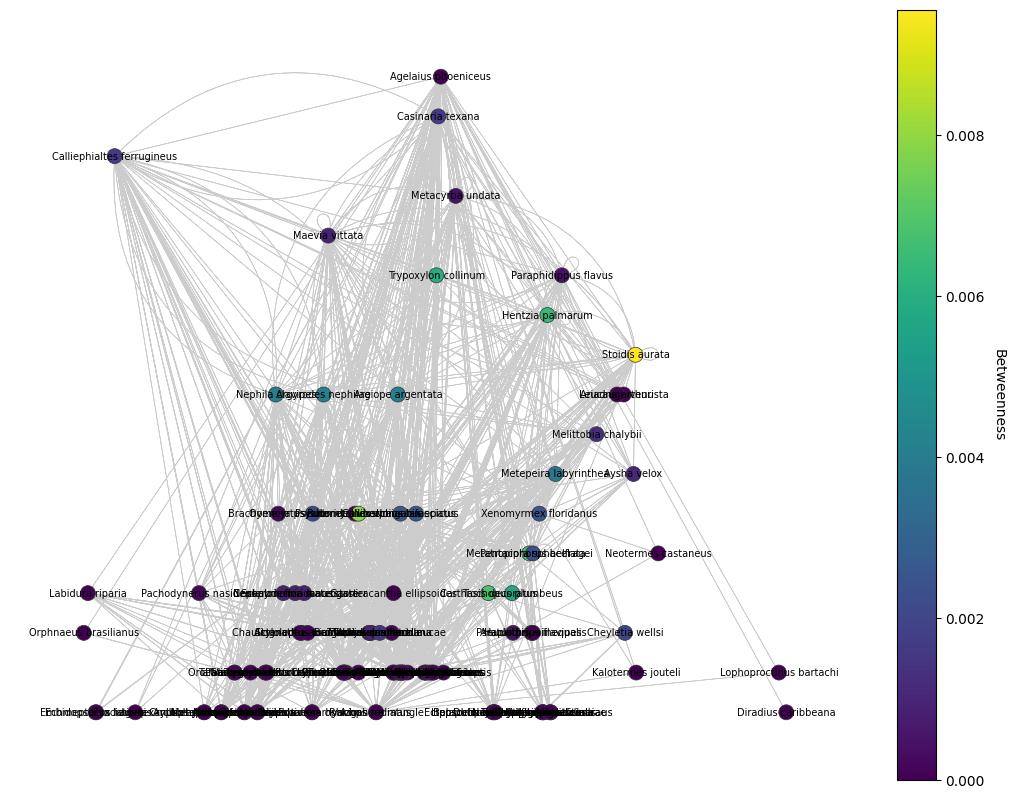

In [145]:
fig_b, ax_b = plt.subplots(figsize=(12,10))

plotar_metrica(
    g,
    atributo='betweenness',
    ax = ax_b
)

### Page Rank

In [146]:
page_rank_values = g.pagerank(directed=True)

dados = []
for i, node in enumerate(g.vs):
    node_data = {
        'nome': node['name'],
        'grau_in': node.indegree(),
        'grau_out': node.outdegree(),
        'page_rank': page_rank_values[i]
    }
    dados.append(node_data)
    node['page_rank'] = betweenness_values[i]

#printar_estatistica(dados, 'page_rank')

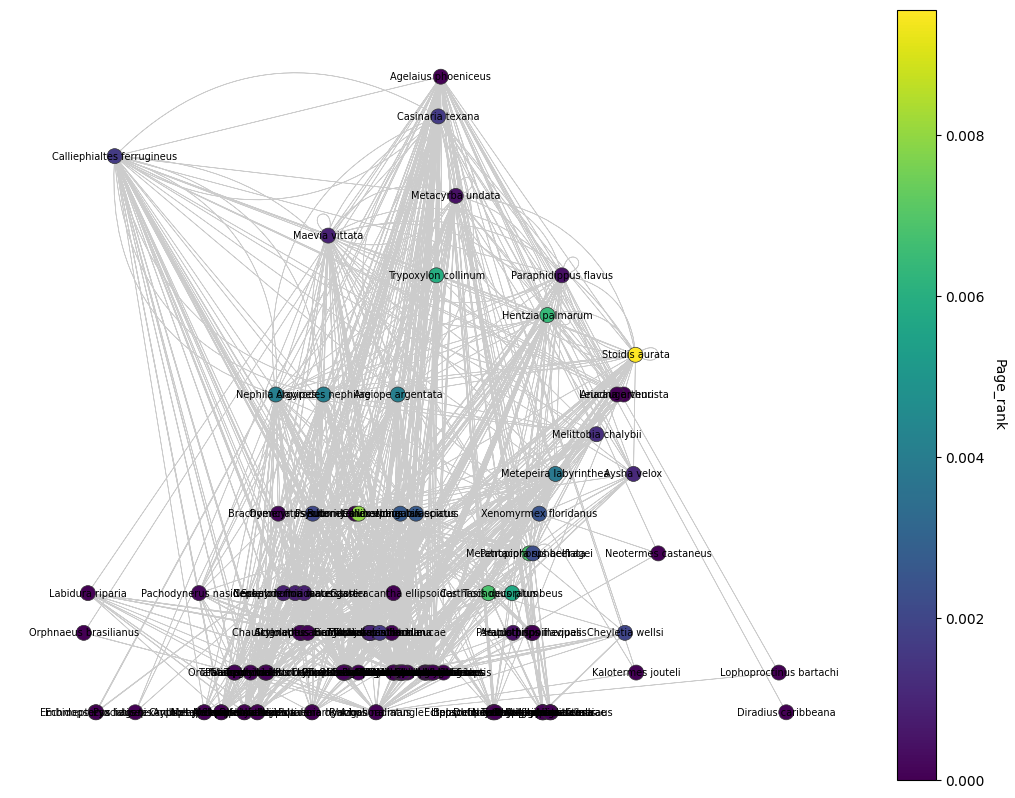

In [147]:
fig_b, ax_b = plt.subplots(figsize=(12,10))

plotar_metrica(
    g,
    atributo='page_rank',
    ax = ax_b
)

### Edge Betweenness

In [148]:
comunidades_betweenness = g.community_edge_betweenness(directed=True)
for idx, comunidade in enumerate(comunidades_betweenness.as_clustering()):
    print(f'{idx} - {comunidade}',end=', ', flush=True)
    if idx % 4 == 0: print()
print()

0 - [0], 
1 - [1], 2 - [2, 3, 4, 7, 8, 23, 24, 25, 29, 31, 32, 36, 46, 49, 50, 51, 52, 54, 55, 56, 58, 60, 61, 62, 64, 65, 67, 68, 69, 70, 71, 72, 76, 77, 78, 80, 81, 83, 84, 85, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 107], 3 - [5, 45, 82], 4 - [6], 
5 - [9], 6 - [10], 7 - [11], 8 - [12], 
9 - [13, 63, 73, 74, 75, 79], 10 - [14], 11 - [15], 12 - [16], 
13 - [17], 14 - [18], 15 - [19], 16 - [20], 
17 - [21], 18 - [22], 19 - [26], 20 - [27], 
21 - [28], 22 - [30], 23 - [33], 24 - [34], 
25 - [35], 26 - [37], 27 - [38], 28 - [39], 
29 - [40], 30 - [41], 31 - [42], 32 - [43], 
33 - [44], 34 - [47], 35 - [48], 36 - [53], 
37 - [57], 38 - [59], 39 - [66], 40 - [86], 
41 - [88], 42 - [103], 43 - [106], 


### Infomap - Fluxo de informação

In [149]:
comunidades_infomap = g.community_infomap()
for idx, comunidade in enumerate(comunidades_infomap):
    print(f'{idx} - {comunidade}',end=', ', flush=True)
    if idx % 4 == 0: print()
print()

0 - [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107], 
1 - [37, 38, 39, 40, 41, 42, 43, 75], 


### Leiden

In [150]:
comunidades_leiden = g.community_leiden()
for idx, comunidade in enumerate(comunidades_leiden):
    print(f'{idx} - {comunidade}',end=', ', flush=True)
    if idx % 4 == 0: print()
print()

0 - [0], 
1 - [1], 2 - [2], 3 - [3], 4 - [4], 
5 - [5], 6 - [6], 7 - [7], 8 - [8], 
9 - [9], 10 - [10], 11 - [11], 12 - [12], 
13 - [13], 14 - [14], 15 - [15], 16 - [16], 
17 - [17], 18 - [18], 19 - [19], 20 - [20], 
21 - [21], 22 - [22], 23 - [23], 24 - [24], 
25 - [25], 26 - [26], 27 - [27], 28 - [28], 
29 - [29], 30 - [30], 31 - [31], 32 - [32], 
33 - [33], 34 - [34], 35 - [35], 36 - [36], 
37 - [37], 38 - [38], 39 - [39], 40 - [40], 
41 - [41], 42 - [42], 43 - [43], 44 - [44], 
45 - [45], 46 - [46], 47 - [47], 48 - [48], 
49 - [49], 50 - [50], 51 - [51], 52 - [52], 
53 - [53], 54 - [54], 55 - [55], 56 - [56], 
57 - [57], 58 - [58], 59 - [59], 60 - [60], 
61 - [61], 62 - [62], 63 - [63], 64 - [64], 
65 - [65], 66 - [66], 67 - [67], 68 - [68], 
69 - [69], 70 - [70], 71 - [71], 72 - [72], 
73 - [73], 74 - [74], 75 - [75], 76 - [76], 
77 - [77], 78 - [78], 79 - [79], 80 - [80], 
81 - [81], 82 - [82], 83 - [83], 84 - [84], 
85 - [85], 86 - [86], 87 - [87], 88 - [88], 
89 - [89], 90 - [9

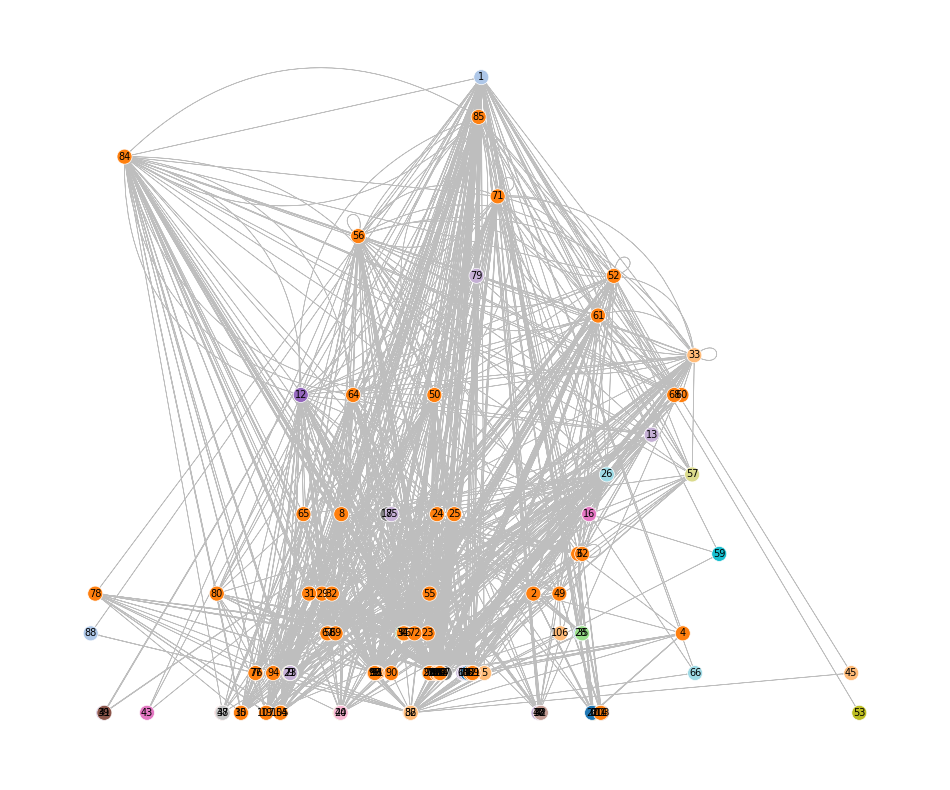

In [151]:
fig, ax = plt.subplots(figsize=(12,10))

plotar_comunidades(
    g,
    comunidades_betweenness.as_clustering(),
    ax=ax,
)